In [6]:
from model_settings import ms
import requests
import numpy as np
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import QuantLib as ql

In [7]:
key = ms.av_key
symbol = 'SPY'
date = '2024-05-17'

In [8]:
underlying_url = str(
    "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY"
    f"&symbol={symbol}&date={date}&outputsize=compact&apikey={key}"
    )
spotr = requests.get(underlying_url)
spots = pd.DataFrame(spotr.json()['Time Series (Daily)']).T
spots = spots.astype(float)

spots.index = pd.to_datetime(spots.index,format='%Y-%m-%d')
spot = float(spots['4. close'][date])
spot

529.45

In [9]:
options_url = str(
    "https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&"
    f"symbol={symbol}"
    f"&date={date}"
    f"&apikey={key}"
          )

r = requests.get(options_url)
data = r.json()

In [10]:
spot

529.45

In [11]:
df = pd.DataFrame(data['data'])
columns_to_convert = ['strike', 'last', 'mark',
       'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest',
       'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho']
df[columns_to_convert] = df[
    columns_to_convert].apply(pd.to_numeric, errors='coerce')

df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['days_to_maturity'] = df['expiration'] - df['date']
df['days_to_maturity'] = df['days_to_maturity'] / np.timedelta64(1, 'D')
df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]

df = df[df['volume']>0].copy()

df['spot_price'] = spot
df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
indexed = df.copy().set_index(['strike','days_to_maturity'])

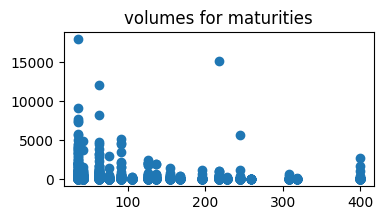

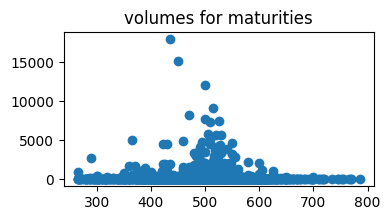

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(4,2))
plt.scatter(df['days_to_maturity'],df['volume'])
plt.title('volumes for maturities')
plt.show()
plt.figure(figsize=(4,2))
plt.scatter(df['strike'],df['volume'])
plt.title('volumes for maturities')
plt.show()
plt.clf()

In [13]:
s = spot
T = np.sort(df['days_to_maturity'].unique()).tolist()
K = np.sort(df['strike'].unique()).tolist()
volume_heatmap = pd.DataFrame(np.full((len(K), len(T)), np.nan), index=K, columns=T)
for k in K:
    for t in T:
        try:
            volume_heatmap.loc[k,t] = indexed.loc[(k,t),'volume']
        except Exception:
            pass

In [14]:
hottest = 50

In [15]:
hottest_contracts = pd.DataFrame(volume_heatmap.unstack().sort_values(ascending=False)).head(hottest).reset_index()
hottest_contracts.columns = ['t','k','volume']
T = np.sort(hottest_contracts['t'].unique()).tolist()
K = np.sort(hottest_contracts['k'].unique()).tolist()

vol_matrix = pd.DataFrame(
    np.full((len(K),len(T)),np.nan),
    index = K,
    columns = T
)
for k in K:
    for t in T:
        try:
            vol_matrix.loc[k,t] = indexed.loc[(k,float(t)),'implied_volatility']
        except Exception:
            pass

vol_matrix = vol_matrix.dropna().copy()
T = vol_matrix.columns.tolist()
K = vol_matrix.index.tolist()

In [16]:
df.columns

Index(['contractID', 'symbol', 'expiration', 'strike', 'type', 'last', 'mark',
       'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest', 'date',
       'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho',
       'days_to_maturity', 'spot_price', 'moneyness'],
      dtype='object')

In [17]:
cols_to_map = [
        'contractID', 'symbol', 'expiration', 'type', 'last', 'mark',
        'bid', 'bid_size', 'ask', 'ask_size', 'volume', 'open_interest', 'date',
        'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho',
        'spot_price', 'moneyness'
]
for col in cols_to_map:
    for i,row in hottest_contracts.iterrows():
        hottest_contracts.at[i,col] = indexed.loc[(row['k'],row['t']),col]

In [18]:
hottest_contracts.columns

Index(['t', 'k', 'volume', 'contractID', 'symbol', 'expiration', 'type',
       'last', 'mark', 'bid', 'bid_size', 'ask', 'ask_size', 'open_interest',
       'date', 'implied_volatility', 'delta', 'gamma', 'theta', 'vega', 'rho',
       'spot_price', 'moneyness'],
      dtype='object')

# Plots